# Bagmati catchment
# Hyperparameter tuning using model_builder function from tensorflow   (Standard normalization)
(After midterm)
#(https://www.tensorflow.org/tutorials/keras/keras_tuner)
### Random search tuner

In [1]:
import numpy as np
import pandas as pd

### define file path
path = 'Non_scaled_6_input_Bagmati_yr.csv'  ####### This excel data is not scaled/normalized
## Read CSV file and convert it to dataframe
df = pd.read_csv( path, sep = ',', header = 'infer')


In [2]:
df

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.878,25.060,3.613,8.190,1.608,28.160,299.0
1,0.000,0.878,25.060,3.613,8.190,1.608,182.0
2,25.527,0.000,0.878,25.060,3.613,8.190,151.0
3,36.896,25.527,0.000,0.878,25.060,3.613,561.0
4,6.184,36.896,25.527,0.000,0.878,25.060,384.0
...,...,...,...,...,...,...,...
2909,7.115,0.422,7.130,13.781,4.314,18.381,132.0
2910,3.118,7.115,0.422,7.130,13.781,4.314,107.0
2911,61.877,3.118,7.115,0.422,7.130,13.781,538.0
2912,112.900,61.877,3.118,7.115,0.422,7.130,921.0


In [3]:
df.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000
mean,5.433136,5.434821,5.397316,5.378893,5.378374,5.385596,149.648264
std,14.030448,14.032511,13.890520,13.851130,13.851243,13.857633,271.208820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.700000
75%,4.916000,4.916000,4.864500,4.864500,4.864500,4.864500,195.975000
max,364.590000,364.590000,364.590000,364.590000,364.590000,364.590000,5030.000000


# 1. Data splitting

##  Train, Validation and Test data 
###  70% train (2040 data points)
###  15% train (436 data points)
###  15% train (436 data points)

In [4]:
df_train = df.iloc[:2040]

df_val = df.iloc[2040:2476] 

df_test = df.iloc[2476:2912] 

# 2. Normalization

In [5]:
import pandas as pd
import numpy as np

### General function for all the normalization methods

def normalize_df(data, norm_method):     

    ## Normalize data using specified method
 
    if norm_method == 'minmax':
        # Min-Max normalization
        data = (data - data.min()) / (data.max() - data.min())
    elif norm_method == 'zscore':
        # Z-score normalization
        mean = data.mean()
        std = data.std()
        data = (data - mean) / std
    elif norm_method == 'max':
        # Max normalization
        data = 1 - ((data.max() - data)/data.max())
    else:
        raise ValueError("Invalid normalization method. Choose from: 'minmax', 'zscore', 'max'")
    return data



### Standard normalization  (Date sets for training, validation and testing are nromalized separately)

In [6]:
## Z_score(standard)
df_train_norm = normalize_df(df_train, 'zscore')
df_val_norm = normalize_df(df_val, 'zscore')
df_test_norm = normalize_df(df_test, 'zscore')

In [7]:
###example
df_train_norm.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03
mean,-2.590520e-17,5.329615e-16,-1.793772e-16,5.066753e-17,2.870797e-16,-2.443579e-17,2.166023e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-5.277226e-01
25%,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-4.900124e-01
50%,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-3.891311e-01
75%,-5.646773e-02,-5.666901e-02,-5.677197e-02,-5.549026e-02,-5.554508e-02,-5.307515e-02,1.998830e-01
max,2.456513e+01,2.455419e+01,2.455464e+01,2.455494e+01,2.455530e+01,2.454060e+01,1.705836e+01


In [8]:
### convert the dataframes to numpy arrays

df_train_f = df_train_norm.to_numpy()

df_val_f = df_val_norm.to_numpy()

df_test_f = df_test_norm.to_numpy()

In [9]:
### Define input and output sequences (list of sub sequences)

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5, 1    #### 5 input sequences and 2 output sequences



### Split into input and target variables

In [10]:
#### Training data


X_train, y_train = split_sequences(df_train_f, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)

# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 6

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)


(2036, 5, 6) (2036, 1)
(2036, 5, 6)


In [11]:
#### validation data

X_val, y_val = split_sequences(df_val_f , n_steps_in, n_steps_out)


X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

### reshape

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

print(X_val.shape, y_val.shape)


(432, 5, 6) (432, 1)


In [12]:
#### Test data

X_test, y_test = split_sequences(df_test_f , n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape, y_test.shape)


(432, 5, 6) (432, 1)


In [13]:
#### model fitting
import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model

from tensorflow.keras import initializers

from tensorflow.keras import layers


## Hyperparameter tuning using KerasTuner

In [14]:

import keras_tuner as kt


from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.engine.hyperparameters import Choice,Float

### a. Define model (Using model_buider function)
### (https://www.tensorflow.org/tutorials/keras/keras_tuner)
## MLP

In [15]:

def model_builder(hp):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Flatten(input_shape = (n_steps_in, n_features)))   ### flattening is important when using this function
 ###1. Tune the number of units in the first Dense layer
     
    hp_units = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    
###2. Tune the activation function

    hp_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
    
###3. Tune the weight initialization
    hp_initializer=hp.Choice('weight_init', ['he_uniform', 'glorot_uniform', 'random_normal' , 'lecun_normal'])  ##
    
       ### Fix the seeds for reproducibility purposes   
        
    if hp_initializer == 'he_uniform':
        init = tf.keras.initializers.he_uniform(seed=1)
    elif hp_initializer == 'glorot_uniform':
        init = tf.keras.initializers.glorot_uniform(seed=1)
    elif hp_initializer == 'random_normal':
        init = tf.keras.initializers.RandomNormal(seed=1)
    else:
        init = tf.keras.initializers.lecun_normal(seed=1)
    
###4. Tune the number of layers
###5. Tune the dropout rates

    for i in range(hp.Int("num_layers", 1, 3)):
        
        model.add(keras.layers.Dense(units = hp_units, activation = hp_activation, kernel_initializer = init))
        model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
    ### Output layer
   
    model.add(keras.layers.Dense(1, kernel_initializer = init))
    model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
###6. Tune the optimizer 

    hp_optimizer = hp.Choice("optimizer", ['Adam', 'SGD', 'RMSprop'])

    model.compile (
                    optimizer = hp_optimizer,
                  
                    loss='mean_squared_error',
                   
                    metrics=[tf.keras.metrics.MeanSquaredError()])
    
  
    return model

    
 

### b.  Instantiate the tuner and perform hypertuning

In [16]:
from keras_tuner.tuners import RandomSearch

In [17]:
tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='Exhaustive_Opt_norm',
    project_name='Randomsearch_1_MLP_13March'
)

In [18]:
from keras.callbacks import TensorBoard

import datetime, os

log_dir = 'Exhaustive_Opt_norm/Randomsearch_1_MLP_13March'
# tf.keras.callbacks.TensorBoard('Exhaustive_Opt_norm/Randomsearch_1_MLP_13March')


In [19]:
### Create a callback to stop training early after reaching a certain value for the validation loss.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### C. Run hyperparameter search 

# 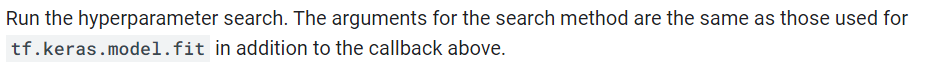

In [20]:
tuner.search(X_train, y_train, 
             epochs=100, 
             validation_data=(X_val, y_val), 
             callbacks=[stop_early, tf.keras.callbacks.TensorBoard('Exhaustive_Opt_norm/Randomsearch_1_MLP_13March')])

Trial 100 Complete [00h 00m 22s]
val_loss: 0.29826176166534424

Best val_loss So Far: 0.2543605864048004
Total elapsed time: 00h 18m 28s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

Results summary
Results in Exhaustive_Opt_norm\Randomsearch_1_MLP_13March
Showing 10 best trials
Trial summary
Hyperparameters:
units: 7
activation: relu
weight_init: random_normal
num_layers: 2
dropout_rate: 0.1
optimizer: RMSprop
Score: 0.2543605864048004
Trial summary
Hyperparameters:
units: 4
activation: relu
weight_init: random_normal
num_layers: 3
dropout_rate: 0.0
optimizer: RMSprop
Score: 0.26067811250686646
Trial summary
Hyperparameters:
units: 7
activation: relu
weight_init: random_normal
num_layers: 3
dropout_rate: 0.0
optimizer: RMSprop
Score: 0.26372361183166504
Trial summary
Hyperparameters:
units: 2
activation: relu
weight_init: random_normal
num_layers: 2
dropout_rate: 0.0
optimizer: Adam
Score: 0.2798628807067871
Trial summary
Hyperparameters:
units: 2
activation: relu
weight_init: glorot_uniform
num_layers: 1
dropout_rate: 0.1
optimizer: SGD
Score: 0.2801353931427002
Trial summary
Hyperparameters:
units: 1
activation: relu
weight_init: he_uniform
num_layers: 1
dropout

### Tensorboard

In [22]:
%load_ext tensorboard
%tensorboard --logdir 'Exhaustive_Opt_norm/Randomsearch_1_MLP_13March'

## d.  get the optimal hyperparameters

In [29]:

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

print(f"""
The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is {best_hps.get('units')}, 
The optimal activation function is {best_hps.get('activation')},
The optimal weight initialization is {best_hps.get('weight_init')}
The optimal optimizer is {best_hps.get('optimizer')}.
The optimal number of layers is {best_hps.get('num_layers')},
The optimal dropout rate is {best_hps.get('dropout_rate')},

""")





The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is 7, 
The optimal activation function is relu,
The optimal weight initialization is random_normal
The optimal optimizer is RMSprop.
The optimal number of layers is 2,
The optimal dropout rate is 0.1,




## e. Train the model using the best model

In [25]:
model = tuner.hypermodel.build(best_hps)


In [26]:
### model training 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mlp_amt_1 = model.fit(X_train, y_train, epochs=300, validation_data = (X_val, y_val), shuffle = 0)# callbacks=[early_stopping])


Epoch 1/250
64/64 [==============================] - 1s 5ms/step - loss: 0.9899 - mean_squared_error: 0.9899 - val_loss: 0.9609 - val_mean_squared_error: 0.9609
Epoch 2/250
64/64 [==============================] - 0s 2ms/step - loss: 0.9279 - mean_squared_error: 0.9279 - val_loss: 0.8516 - val_mean_squared_error: 0.8516
Epoch 3/250
64/64 [==============================] - 0s 3ms/step - loss: 0.8547 - mean_squared_error: 0.8547 - val_loss: 0.7375 - val_mean_squared_error: 0.7375
Epoch 4/250
64/64 [==============================] - 0s 2ms/step - loss: 0.7708 - mean_squared_error: 0.7708 - val_loss: 0.6554 - val_mean_squared_error: 0.6554
Epoch 5/250
64/64 [==============================] - 0s 2ms/step - loss: 0.7068 - mean_squared_error: 0.7068 - val_loss: 0.5932 - val_mean_squared_error: 0.5932
Epoch 6/250
64/64 [==============================] - 0s 3ms/step - loss: 0.7101 - mean_squared_error: 0.7101 - val_loss: 0.5493 - val_mean_squared_error: 0.5493
Epoch 7/250
64/64 [===============

64/64 [==============================] - 0s 3ms/step - loss: 0.2460 - mean_squared_error: 0.2460 - val_loss: 0.2725 - val_mean_squared_error: 0.2725
Epoch 102/250
64/64 [==============================] - 0s 3ms/step - loss: 0.3844 - mean_squared_error: 0.3844 - val_loss: 0.2727 - val_mean_squared_error: 0.2727
Epoch 103/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2627 - mean_squared_error: 0.2627 - val_loss: 0.2740 - val_mean_squared_error: 0.2740
Epoch 104/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2613 - mean_squared_error: 0.2613 - val_loss: 0.2689 - val_mean_squared_error: 0.2689
Epoch 105/250
64/64 [==============================] - 0s 3ms/step - loss: 0.3038 - mean_squared_error: 0.3038 - val_loss: 0.2658 - val_mean_squared_error: 0.2658
Epoch 106/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2734 - val_mean_squared_error: 0.2734
Epoch 107/250
64/64 [===============

64/64 [==============================] - 0s 3ms/step - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2653 - val_mean_squared_error: 0.2653
Epoch 202/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2425 - mean_squared_error: 0.2425 - val_loss: 0.2686 - val_mean_squared_error: 0.2686
Epoch 203/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2226 - mean_squared_error: 0.2226 - val_loss: 0.2637 - val_mean_squared_error: 0.2637
Epoch 204/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2910 - mean_squared_error: 0.2910 - val_loss: 0.2612 - val_mean_squared_error: 0.2612
Epoch 205/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.2599 - val_mean_squared_error: 0.2599
Epoch 206/250
64/64 [==============================] - 0s 3ms/step - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2670 - val_mean_squared_error: 0.2670
Epoch 207/250
64/64 [===============

In [27]:
model.summary()   #### this shows us that the number of layers are 3 in this MLP model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 217       
                                                                 
 dropout_5 (Dropout)         (None, 7)                 0         
                                                                 
 dense_6 (Dense)             (None, 7)                 56        
                                                                 
 dropout_6 (Dropout)         (None, 7)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 8         
                                                                 
 dropout_7 (Dropout)         (None, 1)                

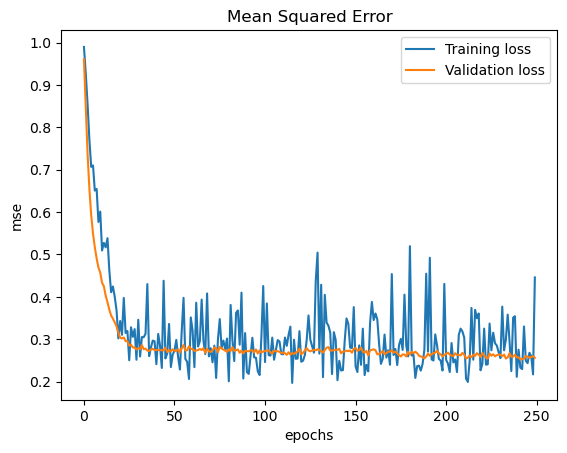

In [33]:
import matplotlib.pyplot as plt

plt.plot(mlp_amt_1.history['mean_squared_error'], label = 'Training loss')
plt.plot(mlp_amt_1.history['val_mean_squared_error'], label = 'Validation loss')
plt.title('Mean Squared Error')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

## f. Test best model

In [34]:
eval_result = model.evaluate(X_test, y_test)
# eval_result = hypermodel.evaluate(X_test, y_test)

print("[test loss, test accuracy]:", eval_result)

14/14 [==============================] - 0s 1ms/step - loss: 0.2670 - mean_squared_error: 0.2670
[test loss, test accuracy]: [0.26701053977012634, 0.26701053977012634]


In [35]:
Y_pred = model.predict(X_test)   ### when using early stopping
# Y_pred = hypermodel.predict(X_test)   

14/14 [==============================] - 0s 2ms/step


In [36]:
Y_pred

array([[-0.46807444],
       [-0.46795362],
       [-0.46810383],
       [-0.46838617],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.4613405 ],
       [-0.37043732],
       [-0.27668172],
       [-0.28275   ],
       [-0.29595447],
       [-0.28450727],
       [-0.20910598],
       [-0.21440676],
       [-0.16430503],
       [-0.11578031],
       [-0.1905217 ],
       [-0.2339349 ],
       [-0.07146633],
       [ 0.21060045],
       [ 0.4112019 ],
       [ 1.4736323 ],
       [ 0.43032962],
       [ 0.7489409 ],
       [ 0.86738676],
       [ 0.6091905 ],
       [ 0.24906974],
       [ 0.7728047 ],
       [ 1.3369399 ],
       [ 0.26777315],
       [ 0.19018956],
       [ 0.19018956],
       [-0.1829859 ],
       [-0.17541191],
       [-0.20087063],
       [-0.21711202],
       [-0.20947517],
       [-0.32450086],
       [-0.22703134],
       [-0.22492374],
       [-0.19489767],
       [ 0

In [37]:
y_test

array([[-5.99860276e-01],
       [-5.97231489e-01],
       [-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-6.01437548e-01],
       [-6.01963306e-01],
       [-6.03540578e-01],
       [-6.04592093e-01],
       [-6.05117850e-01],
       [-6.04592093e-01],
       [-5.86716341e-01],
       [-5.86716341e-01],
       [-5.60428470e-01],
       [-5.71995133e-01],
       [-5.78829979e-01],
       [-5.79355737e-01],
       [-5.74623920e-01],
       [-3.87454278e-01],
       [-4.44761837e-01],
       [-5.17316361e-01],
       [-4.87348188e-01],
       [-3.65372467e-01],
       [ 1.58807682e-01],
       [ 1.19901633e-01],
       [ 7.29254483e-01],
       [ 1.45663746e-01],
       [ 1.55653137e-01],
       [ 1.25159207e-01],
       [-3.43290655e-01],
       [-3.74836100e-01],
       [ 6.06753004e-01],
       [ 9.67683062e-02],
       [-4.00072456e-01],
       [-4.87348188e-01],
       [-4.78936069e-01],
       [-3.62743679e-01],
       [-4.52648198e-01],
       [-5.0

In [38]:
y_test.shape

(432, 1)

In [39]:
print(y_test[:,:-1].shape)   
print(y_test[:,1:2].shape)

(432, 0)
(432, 0)


In [40]:
y_test[:,-1:]    ##### all rows and all columns including -1(which is the last column)

array([[-5.99860276e-01],
       [-5.97231489e-01],
       [-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-6.01437548e-01],
       [-6.01963306e-01],
       [-6.03540578e-01],
       [-6.04592093e-01],
       [-6.05117850e-01],
       [-6.04592093e-01],
       [-5.86716341e-01],
       [-5.86716341e-01],
       [-5.60428470e-01],
       [-5.71995133e-01],
       [-5.78829979e-01],
       [-5.79355737e-01],
       [-5.74623920e-01],
       [-3.87454278e-01],
       [-4.44761837e-01],
       [-5.17316361e-01],
       [-4.87348188e-01],
       [-3.65372467e-01],
       [ 1.58807682e-01],
       [ 1.19901633e-01],
       [ 7.29254483e-01],
       [ 1.45663746e-01],
       [ 1.55653137e-01],
       [ 1.25159207e-01],
       [-3.43290655e-01],
       [-3.74836100e-01],
       [ 6.06753004e-01],
       [ 9.67683062e-02],
       [-4.00072456e-01],
       [-4.87348188e-01],
       [-4.78936069e-01],
       [-3.62743679e-01],
       [-4.52648198e-01],
       [-5.0

## Evaluation metics

In [41]:
###nse

import hydroeval as he
nse = he.evaluator(he.nse, Y_pred, y_test[:,-1:]  )
print(nse)

[0.73394326]


In [42]:
##rmse
rmse = he.evaluator(he.rmse, Y_pred, y_test[:,-1:]  )
print(rmse)

[0.51673058]


In [43]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg = np.log1p(Y_pred)

#### log of test values
y_test_lg = np.log1p(y_test[:,-1:])


In [44]:
##calculate mse
mse = mean_squared_error(y_pred_lg, y_test_lg)
rmse_lg = np.sqrt(mse)   
print(rmse_lg)

0.38109385183892763


## g. plot

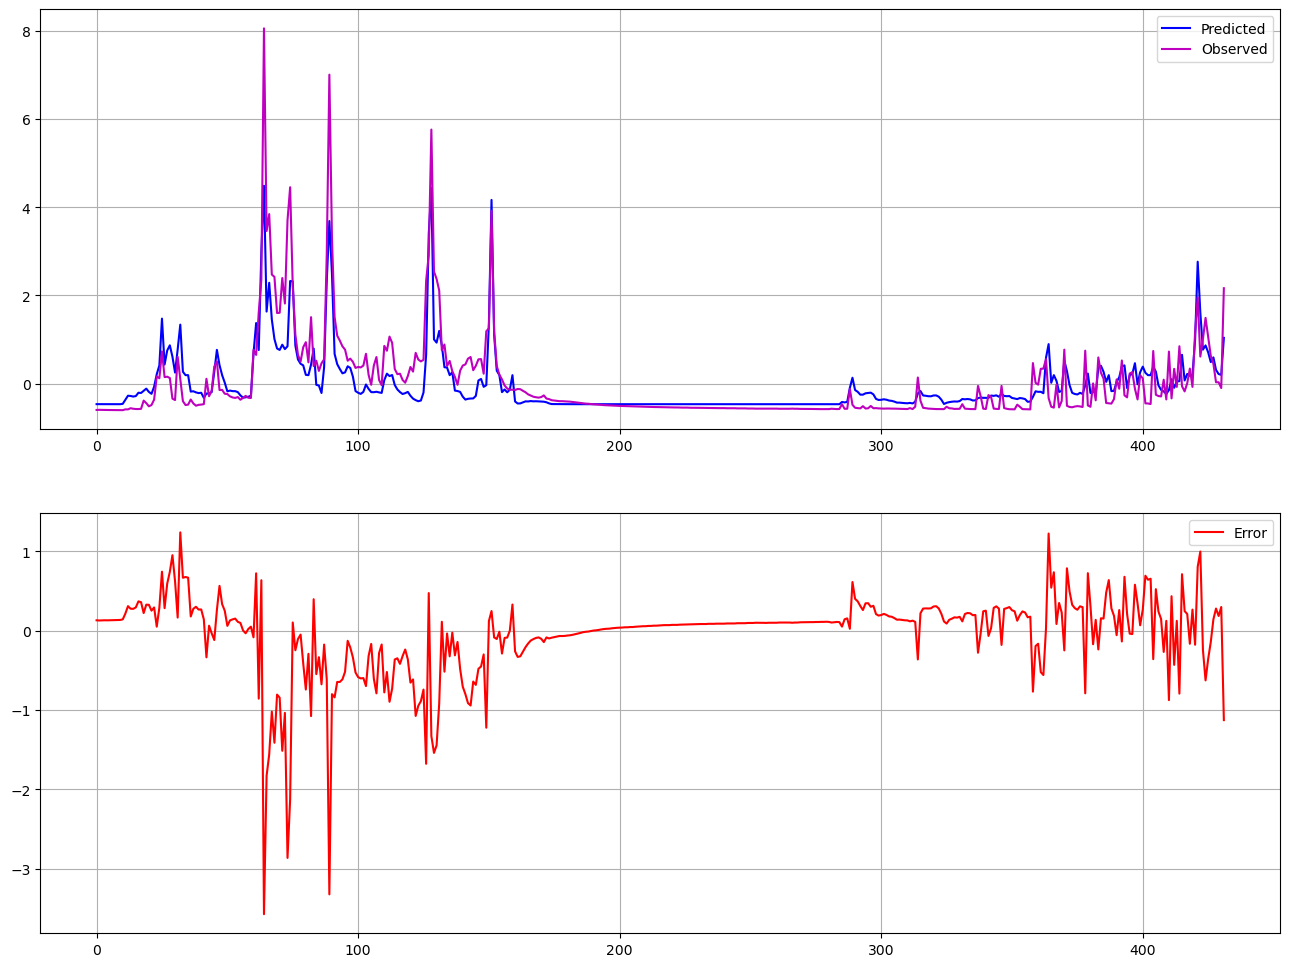

In [45]:
import matplotlib.pyplot as plt
# plt.plot(Q_pred)
# plt.plot(y_test)

plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred[:,-1],'b', label = "Predicted")

plt.plot(y_test[:,-1], 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred[:,-1] - y_test[:,-1],'r', label = "Error")

plt.legend()

plt.grid()

##  save_model

## h. Denormalize the data

In [46]:
#### Original data
df_train_norm

# df_val_f

# df_test_f

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,-0.306768,1.345488,-0.120634,0.191968,-0.258026,1.555244,0.500865
1,-0.366809,-0.307482,1.345417,-0.120909,0.191917,-0.258825,0.091390
2,1.378816,-0.367498,-0.307591,1.345176,-0.120965,0.190866,-0.017104
3,2.156268,1.377410,-0.367608,-0.307870,1.345145,-0.121841,1.417809
4,0.056074,2.154542,1.377339,-0.367889,-0.307929,1.343448,0.798347
...,...,...,...,...,...,...,...
2035,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2036,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2037,-0.362091,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2038,-0.327215,-0.362781,-0.367608,-0.367889,-0.367949,-0.368686,-0.496575


In [47]:
### normalized data after model training
Y_pred    #### model out put
# y_obser = y_test[:,-1:]      ## observed discharge

array([[-0.46807444],
       [-0.46795362],
       [-0.46810383],
       [-0.46838617],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.46904927],
       [-0.4613405 ],
       [-0.37043732],
       [-0.27668172],
       [-0.28275   ],
       [-0.29595447],
       [-0.28450727],
       [-0.20910598],
       [-0.21440676],
       [-0.16430503],
       [-0.11578031],
       [-0.1905217 ],
       [-0.2339349 ],
       [-0.07146633],
       [ 0.21060045],
       [ 0.4112019 ],
       [ 1.4736323 ],
       [ 0.43032962],
       [ 0.7489409 ],
       [ 0.86738676],
       [ 0.6091905 ],
       [ 0.24906974],
       [ 0.7728047 ],
       [ 1.3369399 ],
       [ 0.26777315],
       [ 0.19018956],
       [ 0.19018956],
       [-0.1829859 ],
       [-0.17541191],
       [-0.20087063],
       [-0.21711202],
       [-0.20947517],
       [-0.32450086],
       [-0.22703134],
       [-0.22492374],
       [-0.19489767],
       [ 0

In [48]:
def denormalize(data, original_data, type='min_max'):   ### default is min-max in this case(there is no reason behind this)

    if type == 'min_max':
        min = np.min(original_data)
        max = np.max(original_data)
        data = data * (max - min) + min
    elif type == 'z_score':
        mean = np.mean(original_data)
        std = np.std(original_data)
        data = data * std + mean
    elif type == 'max':                
        max = np.max(original_data)
        data = data * max
    else:
        raise ValueError("Invalid normalization type. Choose either 'max', 'min_max', or 'z_score'.")
    return data

In [49]:
Y_observ_unnorm = df_test['Qt']

In [50]:
Y_observ_unnorm = Y_observ_unnorm.to_numpy()

###  denormalized predicted discharge

In [51]:
### Standard denormalization (becasue we used standard(z-score) in this experiment)

Y_pred_denorm = denormalize(Y_pred, Y_observ_unnorm, type='z_score')

In [52]:
print(Y_pred_denorm)
print(Y_pred_denorm.shape)

[[ 37.56806 ]
 [ 37.59102 ]
 [ 37.562477]
 [ 37.508835]
 [ 37.38286 ]
 [ 37.38286 ]
 [ 37.38286 ]
 [ 37.38286 ]
 [ 37.38286 ]
 [ 37.38286 ]
 [ 38.847404]
 [ 56.117508]
 [ 73.92953 ]
 [ 72.77666 ]
 [ 70.26802 ]
 [ 72.4428  ]
 [ 86.76781 ]
 [ 85.76074 ]
 [ 95.27925 ]
 [104.498146]
 [ 90.29851 ]
 [ 82.05072 ]
 [112.917076]
 [166.50513 ]
 [204.61609 ]
 [406.4604  ]
 [208.25005 ]
 [268.78094 ]
 [291.2837  ]
 [242.23067 ]
 [173.81364 ]
 [273.31467 ]
 [380.4911  ]
 [177.36699 ]
 [162.62738 ]
 [162.62738 ]
 [ 91.730194]
 [ 93.16913 ]
 [ 88.33238 ]
 [ 85.246796]
 [ 86.69766 ]
 [ 64.84468 ]
 [ 83.36228 ]
 [ 83.762695]
 [ 89.46715 ]
 [177.09146 ]
 [271.63553 ]
 [206.0146  ]
 [162.62738 ]
 [130.44412 ]
 [ 92.91449 ]
 [ 96.0368  ]
 [ 93.69537 ]
 [ 93.56557 ]
 [ 89.43839 ]
 [ 75.22279 ]
 [ 65.46849 ]
 [ 67.15971 ]
 [ 69.427185]
 [ 73.79924 ]
 [256.12714 ]
 [387.4281  ]
 [271.01495 ]
 [696.48193 ]
 [979.4174  ]
 [436.87524 ]
 [561.00256 ]
 [402.76074 ]
 [318.22388 ]
 [277.68027 ]
 [271.34872 ]
 [293.

### denormalized Observed discharge

In [53]:
len(y_test)

432

In [54]:
Y_obser_denorm = denormalize(y_test, Y_observ_unnorm, type='z_score')

In [55]:
Y_obser_denorm 

array([[  12.53091742],
       [  13.0303437 ],
       [  12.73068793],
       [  12.43103217],
       [  12.43103217],
       [  12.23126166],
       [  12.1313764 ],
       [  11.83172063],
       [  11.63195012],
       [  11.53206487],
       [  11.63195012],
       [  15.0280488 ],
       [  15.0280488 ],
       [  20.02231157],
       [  17.82483595],
       [  16.52632763],
       [  16.42644238],
       [  17.32540967],
       [  52.88456055],
       [  41.99706773],
       [  28.2129025 ],
       [  33.90636205],
       [  57.07974127],
       [ 156.66534078],
       [ 149.27383189],
       [ 265.04084274],
       [ 154.16820939],
       [ 156.06602924],
       [ 150.27268444],
       [  61.27492199],
       [  55.28180668],
       [ 241.76757826],
       [ 144.87888065],
       [  50.48731442],
       [  33.90636205],
       [  35.50452613],
       [  57.57916755],
       [  40.4987889 ],
       [  30.90980439],
       [  34.50567358],
       [  35.70429664],
       [  37.502

# Plot the denomalized data

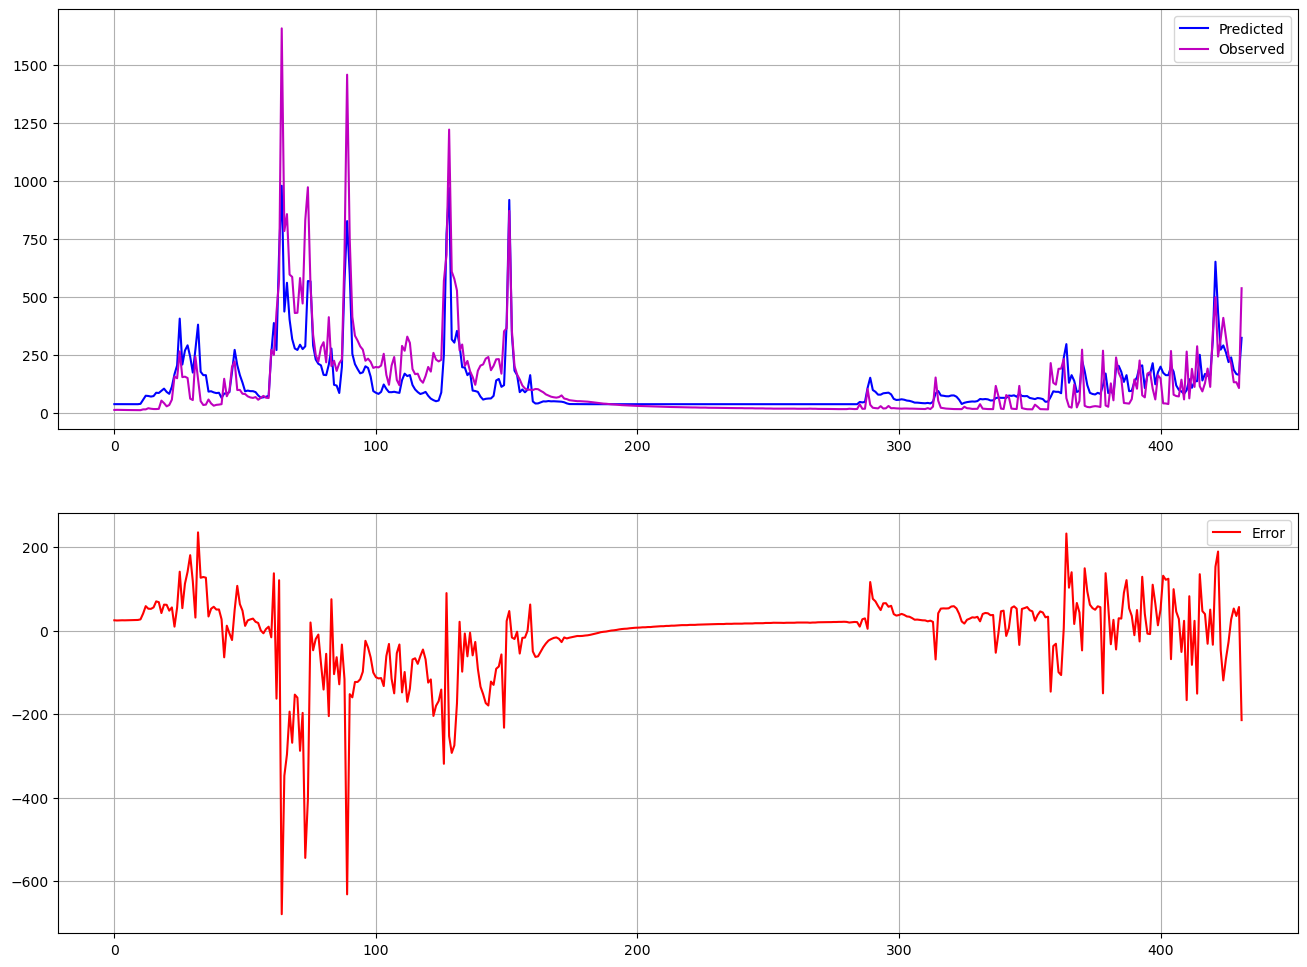

In [56]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_denorm,'b', label = "Predicted")

plt.plot(Y_obser_denorm , 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_denorm - Y_obser_denorm ,'r', label = "Error")

plt.legend()

plt.grid()

### NSE after denormalization

In [57]:
nse_d = he.evaluator(he.nse, Y_pred_denorm , Y_obser_denorm  )
print(nse_d)

[0.73394325]


### RMSE after denormalization (in m3/sec)

In [58]:
#### rmse in m3/sec
rmse_d = he.evaluator(he.rmse, Y_pred_denorm, Y_obser_denorm)
print(rmse_d)    ### 

[98.17030449]


In [60]:
import os
if not os.path.exists('Hyperparameters_tuning_yr'):
    os.mkdir('Hyperparameters_tuning_yr')


# Save the model inside the directory
model.save('Hyperparameters_tuning_yr/Bagmati_MLP.h5')